# Data Inspection

**Prerequisite:** It is a prerequisite for this notebook that the  `binary-matrix.sh` and `time-series.sh` scripts have been run on the data folder of interest.

#### Structure of this notebook:  
    **Exploring the data and descriptive statistics:**   

    A. Package and Data Load  
    B. Understanding the Likers & Retweeters datasets  
    C. Understanding script performance
    D. Understanding user activity

# A. Package and Data Load
Specify your data directory in this section (`my_pull`).

In [64]:
import os
import glob
import json
import pandas as pd
import csv
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import itertools
from matplotlib import pyplot as plt
from collections import Counter
from ast import literal_eval
newest_pull_directory = max(glob.glob('../Pull*'), key=os.path.getmtime)
from resources.datainspection import *

`my_pull`: Set the data directory you want to inspect, e.g. Pull-DD-MM-YYYY-hour:minute:second, or use the newest by setting `my_pull = newest_pull_directory`.

In [65]:
my_pull = newest_pull_directory
my_pull

'../Pull-Big'

Load the data.

The data structures are described further below. In overview,
- `likers` is the dataframe of tweets and all their observed likers,
- `finalharvest_l` is the dataframe of tweets and likers observed during the final harvest,
- `retweeters` and `finalharvest_r` are the same, but for retweeeters.
- `timeseries_likes` and `timeseries_likes` are dataframes with all like/retweet counts over time.

In [66]:
likers = pd.read_pickle(os.path.join(my_pull,'binary-matrix-likers.pkl'))
retweeters = pd.read_pickle(os.path.join(my_pull,'binary-matrix-retweeters.pkl'))
finalharvest_l = pd.read_pickle(os.path.join(my_pull,'likers_final_harvest_complete.pkl'))
finalharvest_r = pd.read_pickle(os.path.join(my_pull,'retweeters_final_harvest_complete.pkl'))
finalharvest_l.index.names = ['tweet']
finalharvest_r.index.names = ['tweet']
timeseries_likes = pd.read_pickle(os.path.join(my_pull,'timeseries_likes.pkl'))
timeseries_retweets = pd.read_pickle(os.path.join(my_pull,'timeseries_retweets.pkl'))

# B. Exploring

## Summary Numbers

The following dataframe includes some summary totals of both `likers` and `retweeters`:

In [67]:
totals = pd.DataFrame()
totals.loc[1,'Total no. of: Liked Tweets'] = likers.shape[0]
totals.loc[1,'Likers'] = likers.shape[1]
totals.loc[1,'Likes'] = sum(likers.sum(axis = 1, skipna = True))
totals.loc[1,'Retweeted Tweets'] = retweeters.shape[0]
totals.loc[1,'Retweeters'] = retweeters.shape[1]
totals.loc[1,'Retweets'] = sum(retweeters.sum(axis = 1, skipna = True))
totals

,Total no. of: Liked Tweets,Likers,Likes,Retweeted Tweets,Retweeters,Retweets
1,2921.0,14658.0,42874.0,645.0,1895.0,3328.0


## Likes and Retweets over Time

We look at `timeseries_likes` and `timeseries_retweeets` to see the likes and retweets of our tweets develop over time, by plotting them.

Pay atention to whether the plotlines are generally only increasing. The more up- and down oscillation you see, the less precise the below estimation of dataset completetion will be.

In [68]:
likes_transposed = timeseries_likes.T
retweets_transposed = timeseries_retweets.T

<AxesSubplot: >

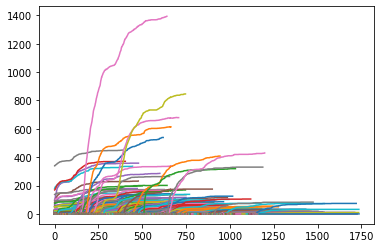

In [69]:
# All tweets:
likes_transposed.plot.line(legend=False)
# 
# Subset only:
# likes_transposed.iloc[:,0:20].plot.line(legend=False)

<AxesSubplot: >

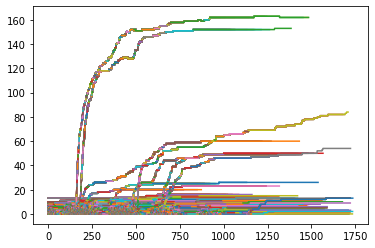

In [70]:
# All tweets:
retweets_transposed.plot.line(legend=False)
# 
# Subset only:
# retweets_transposed.iloc[:,0:20].plot.line(legend=False)

You may notice that some line end before others. That's because we stopped tracking the tweet then.

Take a ppek at `timeseries_retweets.head()`, and see that tweets will stop have recorded retweet counts, but start showing `NanN`.

In [71]:
timeseries_retweets.head()

,0,1,2,3,4,5,6,7,8,9,...,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736
1537521151215382533,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1537520976086421504,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1537520688340295690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1537520502897528832,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1537520221921193986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If you want to look up the like/retweet count of a given tweet at a given time, you can use syntax like this:

timeseries_retweets.at[1537520976086421504,2]

timeseries_retweets.loc[1537520976086421504,2]

timeseries_retweets.iloc[1,2])

## Lists of Likers

Let us look at the dataset of liking users, stored in  `likers`. In `likers`, the row index is tweet ID and the column names are user names. A cell contains `1` if the user liked the tweet, else `NaN`. Both rows and columns are sorted: rows numerically, columns alphabetically. The `retweeters` and `finalharvest_` dataframes are structured in the same way.

This section provides some examples of how to prod the `likers` matrix.

To find some tweet IDs, we may want to look up at the subsection of the first 3 tweets and the first 5 users, using `.iloc`:

In [72]:
likers.iloc[0:3,0:5]

,00Skibsted,0707Klaus,0neNin3Sierra,0oMado0,0ppermann
tweet,,,,,
1537359327786201088,NaN,NaN,NaN,NaN,NaN
1537359346006466560,NaN,NaN,NaN,NaN,NaN
1537359351882522624,NaN,NaN,NaN,NaN,NaN


Or perhaps we want to look at the tweets with the highest like count (retweet count) at the time of final harvest:

In [73]:
finalharvest_l[['like_count']]
#finalharvest_r[['retweet_count']]

,like_count
tweet,
1537739470379925504,1394
1537889632557228033,846
1537834780556939264,680
1537772612989902848,614
1537709471476199424,539
...,...
1537435521806258176,10
1537725068016599042,10
1537741827729661953,10


As the index is the tweet ID, we can look up the row of a single tweet by using its ID and `.loc`. 
Here, we pass the list `[tweet]` to return a nice looking dataframe. If you'd rather want just a series, pass just `tweet`.

In [74]:
tweet = 1537712147500781569
# likers.loc[tweet] # Series
likers.loc[[tweet]] # Dataframe

,00Skibsted,0707Klaus,0neNin3Sierra,0oMado0,0ppermann,1000Tusindfryd,1000paaroed,10ralphjade10,123Heimdal123,123_jill,...,zevo_bte,zneacer,znip101,zoe_elkaer,zoega_b,zootopiavivared,zorendk,zu_gabby,zuiseart,zuluzim909
tweet,,,,,,,,,,,,,,,,,,,,,
1537712147500781569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can subset `likes` to only users that have liked the tweet by dropping columns with NaN values:

In [75]:
likers.loc[[tweet]].dropna(axis='columns')

,10ralphjade10,4Sorensen,A_Petersson94,AllanGeert,Amalieskou,AndreasZilcken,AnnaThyra,AnnetteGregers,Anning09,AugustKnudsbo,...,sofielippert,sorenklit,spedsbjerg,sten_kristensen,svaneklinkcph,sylvest90488612,torbenlollike,vbis92,villads_e,whiteberg
tweet,,,,,,,,,,,,,,,,,,,,,
1537712147500781569,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We get a list of the liking users of the tweet by listing the columns names:

In [76]:
likers.loc[[tweet]].dropna(axis='columns').columns.values.tolist()

['10ralphjade10',
 '4Sorensen',
 'A_Petersson94',
 'AllanGeert',
 'Amalieskou',
 'AndreasZilcken',
 'AnnaThyra',
 'AnnetteGregers',
 'Anning09',
 'AugustKnudsbo',
 'BBilstrup',
 'Baumspieler',
 'BettinaZeeberg',
 'BirgitteVeders',
 'BjrnHansen2',
 'BrianArlyJac',
 'Britter78',
 'BrixLiselotte',
 'BuggeMalene',
 'Chogsbro',
 'ChrLottrup',
 'ChristianAaby',
 'ChuckDecoder',
 'ClausenMorten',
 'Cqmillq',
 'EHeunicke',
 'FormandHummel',
 'FrauDittmar',
 'GTaagaard',
 'GabelAusti',
 'GreaterCph',
 'HNevers',
 'HPHenriksen',
 'HanneCroft',
 'Hesc1007',
 'Hskak',
 'Hstoringgaard',
 'Ingetingeling',
 'JanHoeghJensen',
 'Jennyboeving',
 'JensFick',
 'JensNielsen1',
 'JesperStral',
 'Jesper_Pet',
 'JhaAnder',
 'JoelErKonge',
 'JohnniDrost',
 'JrgenAn82850445',
 'KarinaNielsen1',
 'KevinHoej',
 'KimNiel90162108',
 'KirstenJensine',
 'Klevang',
 'Kristia60802532',
 'Lau_HC',
 'LenaHolmOlsen',
 'LeneRiisager',
 'Lynne_B_Hansen',
 'MadsMolina',
 'Malte_Durum',
 'Marcusdaniels94',
 'MariaBBjoern',
 '

## C. Checking dataset completeness

TODO: Rewrite this:

This section investigates how complete the dataset is with respect to the collected likers and retweeters. 

To evaluate how complete the dataset is, we compare the number of likers/retweeters the script curated per tweet to the number of likes/retweets the tweet has a final harvest.

This is not bulletproof way of measuring completeness: A tweet may have gotten 100 early on that the script misses, then slowly get a 100 more that the script all gets, while the first 100 unlike or have their accounts deleted. The measure would not inform us that we missed out, but tell us that we got 100/100 likers.

To use this measure, the tweets must have been surveyed during the final harvest, so we subset to those below.

### C0. Maximal Like and Retweet Counts

To implement the completeness measure, we add the final harvest like/retweet count to the timeseries dataframes,so we can find the maximum number of lieks/retweets across all observations:

In [77]:
timeseries_likes_all = timeseries_likes
timeseries_retweets_all = timeseries_retweets
for tweet in finalharvest_l.index:
    timeseries_likes_all.at[tweet,'final'] = finalharvest_l.at[tweet,'like_count']
for tweet in finalharvest_r.index:
    timeseries_retweets_all.at[tweet,'final'] = finalharvest_r.at[tweet,'retweet_count']

max_likes = timeseries_likes_all.max(axis=1)
max_retweets = timeseries_retweets_all.max(axis=1)

For fun, let us print the tweets IDs of the tweets with most likes and retweets:

In [78]:
print("Likes:   ", max_likes.idxmax(), max_likes.max())
print("Retweets:", max_retweets.idxmax(), max_retweets.max())

Likes:    1537739470379925504 1394.0
Retweets: 1538459215160819712 163.0


### C1. How many tweets were included in the final harvest?

As we below subset to tweet included in the final harvest, it may be of interest to know how large a portion of all collected tweets this is:

In [83]:
all_vs_finalharvest = pd.DataFrame()
all_vs_finalharvest.loc[1,'Liked: All |'] = likers.shape[0]
all_vs_finalharvest.loc[1,'Final harvest L |'] = finalharvest_l.shape[0]
all_vs_finalharvest.loc[1,'%'] = (finalharvest_l.shape[0]/likers.shape[0])*100
all_vs_finalharvest.loc[1,'// Retweeted: All |'] = retweeters.shape[0]
all_vs_finalharvest.loc[1,'Final harvest R'] = finalharvest_r.shape[0]
all_vs_finalharvest.loc[1,'%'] = (finalharvest_r.shape[0]/retweeters.shape[0])*100
all_vs_finalharvest = all_vs_finalharvest.apply(np.floor).astype('int')
all_vs_finalharvest

,Liked: All |,Final harvest L |,%,// Retweeted: All |,Final harvest R
1,2921,1203,623,645,4024


# TODO: Clean up this section: What do we need and not need now that we use `max_likes` and `max_retweets`?


### C2. Plot overviews of missed likers and retweeters

This section gives a visual overview of how complete the dataset is (again, measured by number of collected likers vs. like count at final harvest).

In [85]:
subset_likerscomplete = pd.merge(likers, finalharvest_l, left_index=True, right_index=True)
subset_retweeterscomplete = pd.merge(retweeters, finalharvest_r, left_index=True, right_index=True)
# like count at time of final harvest
likecount = finalharvest_l['like_count']
# number of collected likers script performance
likerscollected = subset_likerscomplete.sum(axis = 1, skipna = True) 
# retweet count at time of final harvest
retweetcount = finalharvest_r['retweet_count']
# number of collected retweeters
retweeterscollected = subset_retweeterscomplete.sum(axis = 1, skipna = True) 

### C2.1 Absolute number of missed likers and retweeters 

This plot presents the absolute number of missed likers (blue) and retweeters (orange), with tweets on the x-axis and the number of missed likers and retweeters on the y-axis. 

You learn how many likers/retweeters the script missed in collecting, e.g. due a large batch (say, 200) placed simulataneously.

The tweet with the most absolute missed likers is found in Sec. C3 below.

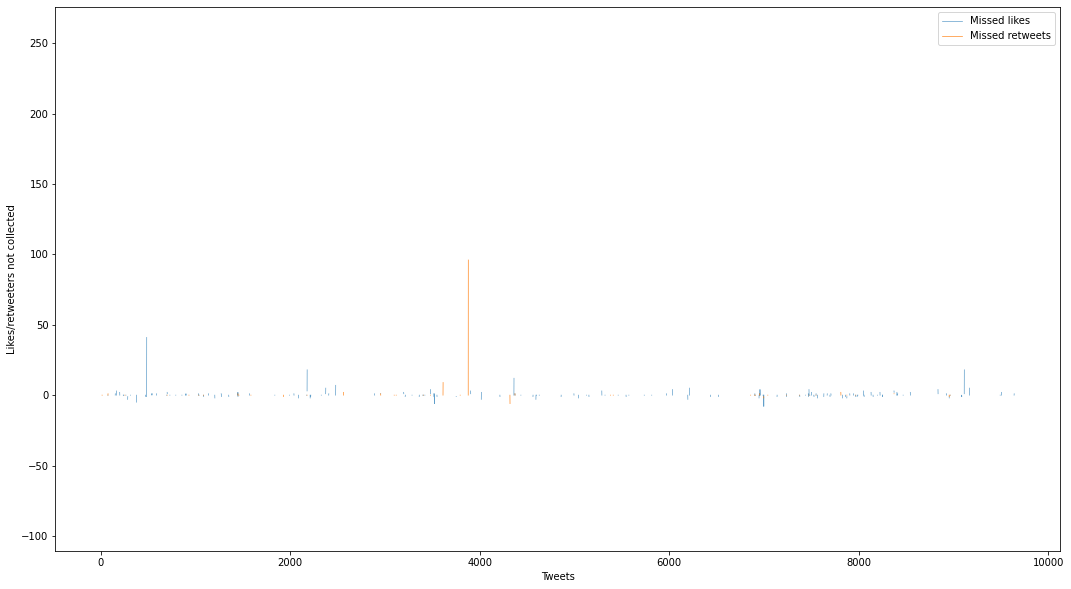

In [86]:
# Absolute number of missed likes/retweets per tweet
plot_missed(max_likes, likerscollected, max_retweets, retweeterscollected)

### C2.2 Relative number of missed likers and retweeters

This plot presents the relative number of missed likes (blue) and retweets (orange), with tweets on the x-axis and the share of missed likes and retweets on the y-axis. 

You learn how many likers/retweeters relative to the total number of attracted likes/retweets the script missed in collecting.  

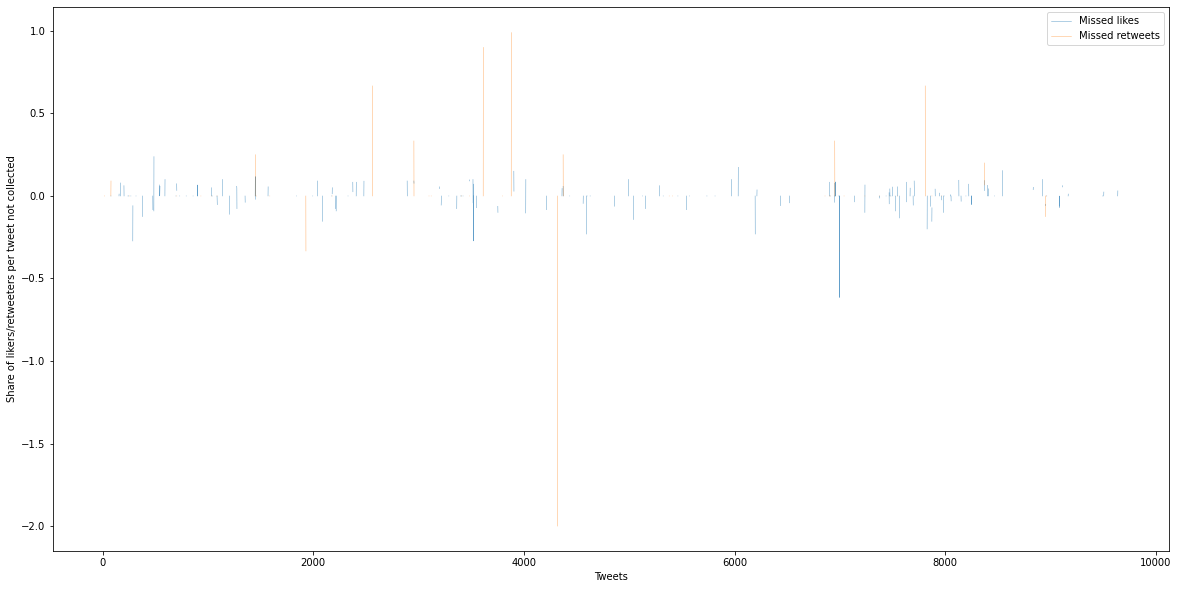

In [87]:
# Share of missed likes/retweets given total of received likes/retweets per tweet
plot_missed_relative(max_likes, likerscollected, max_retweets, retweeterscollected)

### C2.3 Combined absolute and relative missed likers and reweeters.

This plot complements the plot above with the total number of likes/retweets (dotted lines).

You can learn from it that the script priotitises the collection of likers/retweeters for popular tweets. You should see that the script misses out on likers/retweeters relatively less when a tweet attracted many likers/retweeters. The script de-prioritises the collection of likers/retweeters for tweets that get few likes/retweeters.

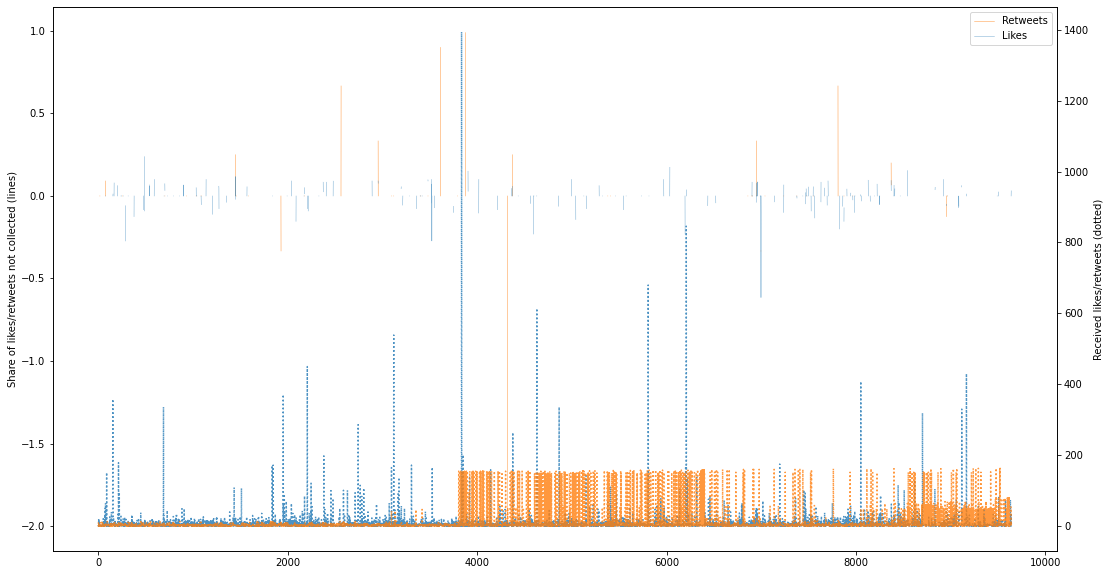

In [88]:
# Supplemented with total number of likes/retweets each tweet attracted: 
plot_missed_relative_absolutecount(max_likes, likerscollected, max_retweets, retweeterscollected)


### C3. Details of missed likers and rewtweeters

We turn to checking in details where likers and retweeters were missed.

The following dataframe lists tweets according to the difference in like count at final harvest and number of collected likers:

In [89]:
# inspect numbers more closely: likers
d = {'Collected likers |': likerscollected, 'Max like count |': max_likes, 'Absolute difference |': max_likes-likerscollected, 'Percent missed': ((max_likes-likerscollected)/max_likes)*100}
inspectlikes = pd.DataFrame(data=d).sort_values(by=['Absolute difference |'], ascending=False)
inspectlikes#.astype({'Collected likers':'int', 'Absolute difference':'int'})

,Collected likers |,Max like count |,Absolute difference |,Percent missed
1537366872043159558,192.0,450.0,258.0,57.333333
1537447141315973122,261.0,336.0,75.0,22.321429
1537383938347376642,304.0,371.0,67.0,18.059299
1537388922371817472,131.0,172.0,41.0,23.837209
1537498098494210048,340.0,358.0,18.0,5.027933
...,...,...,...,...
1539152499596218368,NaN,0.0,NaN,NaN
1539152925867524096,NaN,0.0,NaN,NaN
1539153220026740738,NaN,0.0,NaN,NaN
1539154068572188672,NaN,0.0,NaN,NaN


The following dataframe lists tweets according to the difference in retweet count at final harvest and number of collected retweeters:

In [90]:
# inspect numbers more closely: retweeteres
d = {'Collected retweeters |': retweeterscollected, 'Max retweet count |': max_retweets, 'Absolute difference |': max_retweets-retweeterscollected, 'Percent missed': ((max_retweets-retweeterscollected)/max_retweets)*100}
inspectretweets = pd.DataFrame(data=d).sort_values(by=['Absolute difference |'], ascending=False)
inspectretweets#.astype({'Collected retweeters':'int', 'Absolute difference':'int'})

,Collected retweeters |,Max retweet count |,Absolute difference |,Percent missed
1538459215160819712,1.0,163.0,162.0,99.386503
1537833954203541504,1.0,158.0,157.0,99.367089
1537903305019445250,1.0,152.0,151.0,99.342105
1537757147366301696,1.0,152.0,151.0,99.342105
1538170238042312704,1.0,151.0,150.0,99.337748
...,...,...,...,...
1539153220026740738,NaN,3.0,NaN,NaN
1539154068572188672,NaN,54.0,NaN,NaN
1539167481385951233,NaN,0.0,NaN,NaN
1539168818655858688,NaN,2.0,NaN,NaN


The following dataframe gives you and idea about the number of tweets (in % of all tweets monitored) where the script misses likers/retweeters in the collecton or where the script collected too many (when likes/retweets where deleted/retracted). 

Likers and retweeters are specified in row 1 and 2, respectively. E.g., from the first columnn you can learn for how many (%) tweets the script collected 10 or more too many likers/retweeters. Or, from the last column, you can learn for how mnay tweets (%), the script collected a complete collection of likers/retweeters (compared to time of final harvest). 

In [93]:
perf = pd.DataFrame()
perf.loc[1,'Too many: % with 10 or more too many:'] = round(len(inspectlikes[inspectlikes['Absolute difference |'] <-10])/len(inspectlikes),4)
perf.loc[2,'Too many: % with 10 or more too many:'] = round(len(inspectretweets[inspectretweets['Absolute difference |'] <-10])/len(inspectretweets), 4)

perf.loc[1, 'Too few: % with 10 or more missed:'] = round(len(inspectlikes[inspectlikes['Absolute difference |'] >10])/len(inspectlikes),4)
perf.loc[2, 'Too few: % with 10 or more missed:'] = round(len(inspectretweets[inspectretweets['Absolute difference |'] >10])/len(inspectretweets),4)

perf.loc[1,'Too many: % with 10% or more too many:'] = round(len(inspectlikes[inspectlikes['Percent missed'] <-.1])/len(inspectlikes),4)
perf.loc[2,'Too many: % with 10% or more too many:'] = round(len(inspectretweets[inspectretweets['Percent missed'] >.1] )/len(inspectretweets),4)

perf.loc[1, 'Too few: % with 10% or more missed:'] = round(len(inspectlikes[inspectlikes['Percent missed'] >.1])/len(inspectlikes),4)
perf.loc[2, 'Too few: % with 10% or more missed:'] = round(len(inspectretweets[inspectretweets['Percent missed'] <-.1] )/len(inspectretweets),4)

perf.loc[1, 'Match: % with neither too many nor too few:'] = round(len(inspectlikes[inspectlikes['Absolute difference |'] == 0])/len(inspectlikes),4)
perf.loc[2, 'Match: % with neither too many nor too few:'] = round(len(inspectretweets[inspectretweets['Absolute difference |'] == 0])/len(inspectretweets),4)


perf.index = ['Likes', 'Retweets']

perf

,Too many: % with 10 or more too many:,Too few: % with 10 or more missed:,Too many: % with 10% or more too many:,Too few: % with 10% or more missed:,Match: % with neither too many nor too few:
Likes,0.0003,0.001,0.0250,0.0303,0.0695
Retweets,0.0001,0.001,0.0082,0.0026,0.0561


## D. Understanding user activity

### How many likes/retweets did the users place? How many unique likers/retweeters are in the dataset? 

The following tables and the plot provide some intel about the frequency whith which likers and retweeters were active. You'll learn how many very active users (place many likes/retweets) the dataset contains, how many users are one-time-only active in terms of liking/retweeting. You can explore the frequency tables for this purpose, or look at the plot. In the plot, likers are blue, retweeters are orange, and the number of placed likes/retweetes is found on the x-axis, with the share of likers/retweeters on the y-axis. 

The bottom dataframe summarizes this data. Again, you'll find the data concerning likes and retweets in the rows, respectively. In the columns, we collect some data summaries about, e.g., the (share of/number of) users that placed more than 1 like/retweet, up to the (share of/number of) users that placed more than 50 likes/retweets.

In [94]:
freqtable_l, freqtable_r = make_frequency_table(likers, retweeters)

In [95]:
freqtable_l.head()

,placedlikes,freqlikers
1.0,1.0,8207
2.0,2.0,2350
3.0,3.0,1168
4.0,4.0,711
5.0,5.0,476


In [96]:
freqtable_r.head()

,placedretweets,freqretweeters
1.0,1.0,1353
2.0,2.0,283
3.0,3.0,108
4.0,4.0,44
5.0,5.0,36


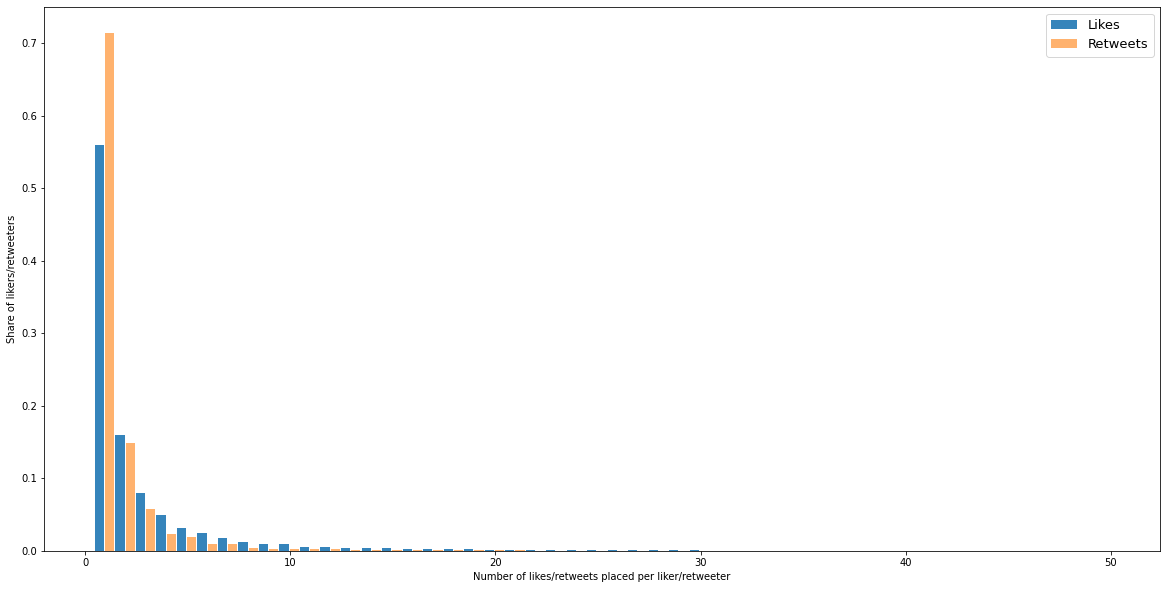

In [97]:
plot_frequency(freqtable_l, freqtable_r)

In [99]:
users = pd.DataFrame()

users.loc[1, 'users placed more than 1:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 1, 'freqlikers'].sum()
users.loc[2,'users placed more than 1:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 1, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 1:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 1, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 1:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 1, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 2:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 2, 'freqlikers'].sum()
users.loc[2,'users placed more than 2:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 2, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 2:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 2, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 2:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 2, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 3:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 3, 'freqlikers'].sum()
users.loc[2,'users placed more than 3:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 3, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 3:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 3, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 3:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 3, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 4:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 4, 'freqlikers'].sum()
users.loc[2,'users placed more than 4:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 4, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 4:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 4, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 4:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 4, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)

users.loc[1, 'users placed more than 50:'] = freqtable_l.loc[freqtable_l['placedlikes'] > 50, 'freqlikers'].sum()
users.loc[2,'users placed more than 50:'] = freqtable_r.loc[freqtable_r['placedretweets'] > 50, 'freqretweeters'].sum()

users.loc[1, '% users placed more than 50:'] = round((freqtable_l.loc[freqtable_l['placedlikes'] > 50, 'freqlikers'].sum())/sum(freqtable_l['freqlikers']),4)
users.loc[2, '% users placed more than 50:'] = round((freqtable_r.loc[freqtable_r['placedretweets'] > 50, 'freqretweeters'].sum())/sum(freqtable_r['freqretweeters']),4)


users.index = ['Likes', 'Retweets']
users


,users placed more than 1:,% users placed more than 1:,users placed more than 2:,% users placed more than 2:,users placed more than 3:,% users placed more than 3:,users placed more than 4:,% users placed more than 4:,users placed more than 50:,% users placed more than 50:
Likes,6451.0,0.4401,4101.0,0.2798,2933.0,0.2001,2222.0,0.1516,10.0,0.0007
Retweets,542.0,0.2860,259.0,0.1367,151.0,0.0797,107.0,0.0565,1.0,0.0005
